# 2025 CITS4012 Project

_Make sure you change the file name with your group id._


In [34]:
import os
import sys
import time
import math
import random
import copy
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from itertools import product

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from gensim.models import KeyedVectors

# NLTK setup
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag

stop_words = set(stopwords.words('english'))

# CUDA info
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

# Adjust sys.path
sys.path.append(os.path.abspath('..'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CUDA available: True
CUDA version: 12.4
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 3060


# Readme


# 1.Dataset Processing


In [13]:
# These are common English contractions.
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match
    
# Allowed POS tags for filtering (example: nouns, verbs, adjectives, adverbs)
allowed_pos_tags = {'NN', 'NNS', 'NNP', 'NNPS',   # Nouns
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  # Verbs
                    'JJ', 'JJR', 'JJS',           # Adjectives
                    'RB', 'RBR', 'RBS'}           # Adverbs

# Filter the desired POS tags
def filter_tokens_by_pos(tokens):
    tagged_tokens = pos_tag(tokens)
    filtered = [word for word, tag in tagged_tokens if tag in allowed_pos_tags]
    return filtered

def clean_dataset(dataset, min_word_len, max_word_len, method=['stem, lemmatize'], pos_filter=False, stop_w=False, clean_nums = False):
    cleaned_premises = []
    cleaned_hypotheses = []
    cleaned_labels = []

    for index, row in dataset.iterrows():
        premise = row['premise']
        hypothesis = row['hypothesis']
        label = row['label']

        # Lowercase
        premise = premise.lower()
        hypothesis = hypothesis.lower()

        # Expand contractions
        for contraction, full_form in contraction_dict.items():
            premise = premise.replace(contraction, full_form)
            hypothesis = hypothesis.replace(contraction, full_form)

        # Remove punctuation/special chars
        premise = re.sub(r'[^a-zA-Z0-9\s.-]', ' ', premise)
        hypothesis = re.sub(r'[^a-zA-Z0-9\s.-]', ' ', hypothesis)

        # Replace underscores/hyphens with spaces, then normalize whitespace
        premise = re.sub(r'[-–—_]+', ' ', premise)
        hypothesis = re.sub(r'[-–—_]+', ' ', hypothesis)

        # Normalize whitespace
        premise = re.sub(r'\s+', ' ', premise).strip()
        hypothesis = re.sub(r'\s+', ' ', hypothesis).strip()

        # Tokenization
        premise_tokens = word_tokenize(premise)
        hypothesis_tokens = word_tokenize(hypothesis)

        # Drop . that are not decimals
        premise_tokens = [t for t in premise_tokens if not (t == '…' or re.fullmatch(r'\.+', t))]
        hypothesis_tokens = [t for t in hypothesis_tokens if not (t == '…' or re.fullmatch(r'\.+', t))]

        # # Replace numbers with '<NUM>'
        if clean_nums is True:
            premise_tokens = ['[NUM]' if any(char.isdigit() for char in word) else word for word in premise_tokens]
            hypothesis_tokens = ['[NUM]' if any(char.isdigit() for char in word) else word for word in hypothesis_tokens]


        # Stemming/Lemmatization
        if 'stem' in method:
            stemmer = PorterStemmer()
            premise_tokens = [stemmer.stem(word) for word in premise_tokens]
            hypothesis_tokens = [stemmer.stem(word) for word in hypothesis_tokens]
        elif 'lemmatize' in method:
            lemmatizer = WordNetLemmatizer()
            premise_pos_tags = pos_tag(premise_tokens)
            hypothesis_pos_tags = pos_tag(hypothesis_tokens)
            premise_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in premise_pos_tags]
            hypothesis_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in hypothesis_pos_tags]

        # POS Filtering
        if pos_filter:
            premise_tokens = filter_tokens_by_pos(premise_tokens)
            hypothesis_tokens = filter_tokens_by_pos(hypothesis_tokens)

        # Remove stop words
        if stop_w:
            premise_tokens = [word for word in premise_tokens if word not in stop_words]
            hypothesis_tokens = [word for word in hypothesis_tokens if word not in stop_words]

        # Now check token length AFTER cleaning
        if (min_word_len <= len(premise_tokens) <= max_word_len and
            min_word_len <= len(hypothesis_tokens) <= max_word_len):
            cleaned_premises.append(premise_tokens)
            cleaned_hypotheses.append(hypothesis_tokens)
            cleaned_labels.append(label)
        # else: skip row

    # Build DataFrame from all cleaned token lists
    new_dataset = pd.DataFrame({
        'premise': cleaned_premises,
        'hypothesis': cleaned_hypotheses,
        'label': cleaned_labels
    })

    return new_dataset

## 1.1 Make the Datasets


In [14]:
# Load raw data
train_df = pd.read_json('../Dataset/train.json')
test_df = pd.read_json('../Dataset/test.json')
validation_df = pd.read_json('../Dataset/validation.json')

min_word_len = 3
max_word_len = 64

# Clean datasets. max_word_len to remove very long texts, and min_word_len to remove texts not containing enough information
clean_train_dataset = clean_dataset(train_df, min_word_len, max_word_len, stop_w=True, method=[], pos_filter=False)
clean_test_dataset = clean_dataset(test_df, min_word_len, max_word_len,stop_w=True, method=[], pos_filter= False )
clean_validation_dataset = clean_dataset(validation_df, min_word_len, max_word_len,stop_w=True, method=[], pos_filter= False )

# Combine clean premises and hypotheses
clean_t_dataset = clean_train_dataset['premise'] + clean_train_dataset['hypothesis']
clean_t_dataset.head()

0    [pluto, rotates, axis, every, 6.39, earth, day...
1    [glenn, per, day, earth, rotates, axis, earth,...
2    [geysers, periodic, gush, hot, water, surface,...
3    [facts, liquid, water, droplets, changed, invi...
4    [comparison, earth, rotates, axis, per, day, r...
dtype: object

In [15]:
# Create a unique word list from the cleaned dataset
unique_words = set()
for sentence in clean_t_dataset: # Both Premise and Hypothesis 
    for word in sentence:
        unique_words.add(word)
        
unique_words_list = sorted(list(unique_words))

# Make dictionary of words and indices
word2id = {w:i for i,w in enumerate(unique_words_list)}
id2word = {i:w for i,w in enumerate(unique_words_list)}


# Add special tokens
SPECIAL_TOKENS = ['[PAD]','[UNK]','[CLS]','[SEP]'] 
for tok in SPECIAL_TOKENS:
    if tok not in word2id:
        idx = len(word2id)
        word2id[tok] = idx
        id2word[idx] = tok


In [16]:
SEP_ID = word2id['[SEP]']
UNK_ID = word2id['[UNK]']
PAD_ID = word2id['[PAD]']
CLS_ID = word2id['[CLS]']


def prepare_indexed_data(df, word2id, max_len):
    input_ids = []
    attention_mask = []
    labels = []

    label_map = {'neutral': 0, 'entails': 1}

    for _, row in df.iterrows():
        premise_toks = row['premise']
        hypothesis_toks = row['hypothesis']
        label = row['label']

        # Add special tokens 
        tokens = [CLS_ID] \
                + [word2id.get(w,UNK_ID) for w in premise_toks] \
                + [SEP_ID] \
                + [word2id.get(w,UNK_ID) for w in hypothesis_toks] 
        # Truncate
        tokens = tokens[:max_len] #to combine len of hypothesis and premise, plus cls and sep  

        # Attention mask 
        attn = [1] * len(tokens)

        # Pad
        pad_len = max_len - len(tokens) # To fill the [PAD]
        if pad_len > 0:
            tokens += [PAD_ID] * pad_len
            attn += [0] * pad_len # FLag positions as padding 

        input_ids.append(tokens)
        attention_mask.append(attn)
        labels.append(label_map[label])

    return (torch.LongTensor(input_ids),
            np.array(input_ids),
            torch.LongTensor(attention_mask),
            torch.LongTensor(labels))

Shape of x_train: torch.Size([22659, 130])
Shape of train_masks: torch.Size([22659, 130])
Shape of y_train: torch.Size([22659])

--- Example ---
First example real length (mask sum): 15
First example PAD count: 115


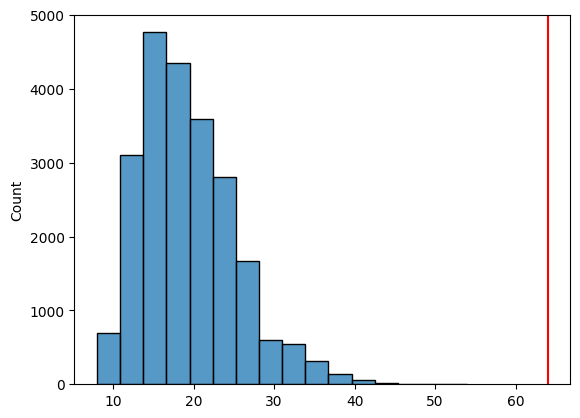

In [17]:
max_combined_len = 130 #to join premise + hypothesis + cls + sep 

# Build train/test
x_train, plain_train, train_masks, y_train = prepare_indexed_data(clean_train_dataset, word2id, max_combined_len)
x_test,  plain_test, test_masks,  y_test  = prepare_indexed_data(clean_test_dataset,  word2id, max_combined_len)
x_valid,  plain_valid, valid_masks,  y_valid  = prepare_indexed_data(clean_validation_dataset,  word2id, max_combined_len)

print("Shape of x_train:", x_train.shape)
print("Shape of train_masks:", train_masks.shape)
print("Shape of y_train:", y_train.shape)

# Sanity Check 
i = 0
print("\n--- Example ---")
print("First example real length (mask sum):", int(train_masks[i].sum()))
print("First example PAD count:", int((train_masks[i]==0).sum()))

# Check we didn't cut off too much
sns.histplot(np.sum(train_masks.numpy(), axis=1), bins = 16)
plt.axvline(max_word_len, color='red')
plt.show()

# Prepare the datasets for model training
train_ds = TensorDataset(x_train, train_masks, y_train)
test_ds = TensorDataset(x_test, test_masks,y_test)
valid_ds = TensorDataset(x_valid, valid_masks,y_valid)

batch_size = 64

# Dataloaders (shuffle for train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)

## 1.2 Make embedding models

In [18]:
# Class construct for hyperparameters, to be used throughout the code
class Config:
    def __init__(self):
        self.embedding_dim = {'rnn': 128, 'transformer': 128, 'wideanddeep': 128}
        self.hidden_dim = {'rnn': 64, 'transformer': 64, 'wideanddeep': 64}
        self.patience = 5
        #Embedding
        self.embedding_method = ""
        self.emb_lr = 0.0005
        self.emb_epoch = 3
        self.emb_window_size = 5
        # Models
        self.n_heads = {'transformer': 2, 'wideanddeep': 2}
        self.n_layers = {'rnn': 2, 'transformer': 2, 'wideanddeep': 2}
        self.classifier_layers = 4
        self.dropout = 0.3
        self.num_classes = 2
        self.lr =  {'rnn': 0.001, 'transformer': 0.0001, 'wideanddeep': 0.0005}
        self.wd = {'rnn': 0.01, 'transformer': 0.01, 'wideanddeep': 0.01}
        self.train_num_epoch = 10
        self.label_smoothing = 0.05

    def display(self): # Display all the config parameters 
        print("=" * 60)
        print("CONFIGURATION PARAMETERS")
        print("=" * 60)
        print("\nEmbedding Parameters:")
        print(f"  Method: {self.embedding_method}")
        print(f"  Max length: {self.max_word_len}")
        print(f"  Learning rate: {self.emb_lr}")
        print(f"  Embedding size: {self.embedding_dim}")
        print(f"  Epochs: {self.emb_epoch}")
        print(f"  Window size: {self.emb_window_size}")
        
        print("\nTransformer Parameters:")
        print(f"  Number of heads: {self.n_heads}")
        print(f"  Number of layers: {self.n_layers}")
        print(f"  Dropout: {self.dropout}")
        print(f"  Number of classes: {self.num_classes}")
        print(f"  Learning rate: {self.lr}")
        print(f"  Weight decay: {self.wd}")
        print(f"  Training epochs: {self.train_num_epoch}")

        print(f"  Label smoothing: {self.label_smoothing}")
        print("=" * 60)
        
hyperparameters = Config()

### Custom Skip Gram Model


In [19]:
# Skip gram model with two embedding layers, for center words and context words
class SkipGramModel(nn.Module):

    def __init__(self, vocab_size, embedding_size):
        super(SkipGramModel, self).__init__()
        # Embedding layer for the center 
        self.embeddings = nn.Embedding(vocab_size, embedding_size, sparse=True)
        # Embedding layer for the context 
        self.output = nn.Embedding(vocab_size, embedding_size, sparse=True)

    def forward(self, center, context, negative):
        v_c = self.embeddings(center)    
        v_o = self.output(context)       
        v_neg = self.output(negative)    
        # Positive Score
        pos_logits = (v_c * v_o).sum(dim=1)

        # Negative score
        neg_logits = (v_c.unsqueeze(1) * v_neg).sum(dim=2)

        return pos_logits, neg_logits
    

class SkipGramPairsDataset(Dataset):

    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        return int(center), int(context)
        

def create_skip_gram_pairs(corpus, word2id, window_size):

    skip_grams = []
    for sentence in corpus:
        sentence_len = len(sentence)
        if sentence_len < 2:
            continue

        for i, center_word in enumerate(sentence):
            if center_word not in word2id:
                continue
            center_id = word2id[center_word]

            # Dynamic window size
            dynamic_window = random.randint(1, window_size)
            start = max(0, i - dynamic_window)
            end = min(sentence_len, i + dynamic_window + 1)

            for j in range(start, end):
                if i == j:
                    continue
                context_word = sentence[j]
                if context_word in word2id:
                    context_id = word2id[context_word]
                    skip_grams.append((center_id, context_id))
    return skip_grams

# Main training process for the Skip-Gram 
def train_skip_gram(dataset, word2id, id2word, vector_size, window, epochs, batch_size, lr, neg_samples=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vocab_size = len(word2id)

    # Create pairs 
    skip_gram_pairs = create_skip_gram_pairs(dataset, word2id, window)
    sg_dataset = SkipGramPairsDataset(skip_gram_pairs)
    loader = DataLoader(sg_dataset, batch_size=batch_size, shuffle=True)

    sg_model = SkipGramModel(vocab_size, vector_size).to(device)
    bce_loss = nn.BCEWithLogitsLoss()
    optimizer = optim.SparseAdam(sg_model.parameters(), lr=lr)

    # Calculate word frequencies for the unigram distribution
    word_counts = Counter(word for sentence in dataset for word in sentence if word in word2id)
    counts_array = np.array([word_counts[id2word[i]] for i in range(vocab_size)], dtype=np.float32)

    sampling_probs = torch.from_numpy(counts_array ** 0.75).to(device)
    sampling_probs /= sampling_probs.sum()

    # Train 
    for epoch in range(epochs):
        total_loss = 0
        for i, (centers, contexts) in enumerate(loader):
            centers, contexts = centers.to(device), contexts.to(device)
            batch_len = centers.size(0)

            neg_context_ids = torch.multinomial(sampling_probs, num_samples=batch_len * neg_samples, replacement=True).view(batch_len, neg_samples)

            pos_logits, neg_logits = sg_model(centers, contexts, neg_context_ids)

            pos_labels = torch.ones_like(pos_logits, device=device)
            neg_labels = torch.zeros_like(neg_logits, device=device)

            loss = bce_loss(pos_logits, pos_labels) + bce_loss(neg_logits, neg_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}")

    print("Custom Skip-Gram training complete.")

    trained_embeddings = sg_model.embeddings.weight.cpu().detach().numpy()
    
    # Create a KeyedVectors instance as gensim 
    kv = KeyedVectors(vector_size=vector_size)
    kv.add_vectors([id2word[i] for i in range(vocab_size)], trained_embeddings)
    
    return kv

### Gensim FastText Model


In [20]:
from gensim.models import FastText

fast_text_model = FastText(clean_t_dataset,
                           vector_size=hyperparameters.embedding_dim['transformer'],
                           window=hyperparameters.emb_window_size,
                           sg=1,
                           epochs=hyperparameters.emb_epoch
                           )

# skip_gram_model = train_skip_gram(clean_t_dataset,
#                                   word2id,
#                                   id2word,
#                                   hyperparameters.embedding_dim,
#                                   window=hyperparameters.emb_window_size,
#                                   epochs=hyperparameters.emb_epoch,
#                                   batch_size=batch_size,
#                                   lr=hyperparameters.emb_lr)

#if skip gram model 
#fast_text_model.most_similar('saturn', topn=10)
#If Fast Text model 
fast_text_model.wv.most_similar('saturn', topn=10)

def build_embedding_matrix(word2id, pretrained_vectors, embedding_size):
    vocab_size = len(word2id)
    embedding_matrix = np.zeros((vocab_size, embedding_size), dtype=np.float32)

    # Fill the matrix with the pre-trained vectors
    for word, idx in word2id.items():
        if word == '[PAD]':# If [PAD] ignore 
            continue
        try:
            vec = pretrained_vectors[word] #Checks the size of the vector of each word
            if vec.shape[0] == embedding_size:
                embedding_matrix[idx] = vec.astype(np.float32)
            else:
                # fallback if dims don’t match
                embedding_matrix[idx] = np.random.normal(0.0, 0.02, size=(embedding_size,)).astype(np.float32)
        except KeyError:
            # special tokens or OOV start them with random values 
            embedding_matrix[idx] = np.random.normal(0.0, 0.02, size=(embedding_size,)).astype(np.float32)

    print("Embedding matrix created with shape:", embedding_matrix.shape)

    return embedding_matrix


#If Skip gram model remove .wv
#embedding_matrix = build_embedding_matrix(word2id, fast_text_model, hyperparameters.embedding_dim)
embedding_matrix = build_embedding_matrix(word2id, fast_text_model.wv, hyperparameters.embedding_dim['transformer'])

Embedding matrix created with shape: (20189, 128)


In [21]:
embedding_matrix = build_embedding_matrix(word2id, fast_text_model.wv, hyperparameters.embedding_dim['transformer'])

Embedding matrix created with shape: (20189, 128)


In [22]:
# Look at embedding matrix with random words
candidates = [i for i in range(embedding_matrix.shape[0]) 
              if id2word.get(i) not in (None, "[PAD]")]

rng = np.random
chosen = rng.choice(candidates, size=min(5, len(candidates)), replace=False)

print(f"{'idx':>4}  {'token':<20}  first 5 dims")
print("-" * 80)
for i in chosen:
    token = id2word[i]
    print(f"{i:>4}  {token:<20}  {embedding_matrix[i][:5]}")

 idx  token                 first 5 dims
--------------------------------------------------------------------------------
1080  adjusted              [-0.03330571  0.21453296 -0.09291957  0.39833325  0.05900676]
11705  metazoans             [0.01637306 0.22292855 0.03549388 0.12939027 0.02271182]
16739  simulating            [ 0.10490049  0.27743813 -0.00605443  0.32956722 -0.08192828]
9157  howtodeduce           [-0.06019486  0.15049286  0.02085937  0.13601644 -0.01846912]
11638  merged                [-0.04252952  0.3942455  -0.0862873   0.5363557   0.14667824]


# 2. Model Implementation


## Model A: RNN with Attention


In [23]:
class LSTMAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, dropout=0.3, num_layers = 2):
        super(LSTMAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x, mask=None, return_weights = False):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        context = self.dropout(context)
        logits = self.fc(context)
        if return_weights:
            return logits, attn_weights
        else:
            return logits

## Model B: Transformer with Attention


In [24]:
# Positional Encoding Module
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len = 512, dropout = 0.1):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0) / d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        x = x + self.pe[:, :x.size(1), :] 
        return self.dropout(x)

In [25]:
# Transformer Classifier Model
class TransformerClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, n_heads, n_layers, dropout):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim

        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False, padding_idx=word2id['[PAD]'])

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=max_combined_len, dropout=hyperparameters.dropout)

        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dropout=hyperparameters.dropout,
            dim_feedforward=(embed_dim*4),
            batch_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,num_layers=n_layers)

        self.classifier = nn.Linear(embed_dim,num_classes)

    def forward(self, x, mask):
        padding_mask = (mask == 0)

        # Apply embedding and positional encoding
        embedded = self.embedding(x) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)

        # Pass through the transformer encoder
        encoded = self.transformer_encoder(pos_encoded,src_key_padding_mask = padding_mask)

        # Use the output of the [CLS] token for classification
        cls_output = encoded[:,0,:]

        # Get final logits from the classifier
        logits = self.classifier(cls_output)
        return logits
    
    # Get attention from the first layer
    def get_attention_weights(self, x, mask):
        # Get embeddings and positional encoding
        padding_mask = (mask == 0)
        embedded = self.embedding(x) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)

        # Access the first encoder layer 
        first_encoder_layer = self.transformer_encoder.layers[0]

        # Call its self-attention module with need_weights=True
        _, attn_weights = first_encoder_layer.self_attn(
            pos_encoded, pos_encoded, pos_encoded,
            key_padding_mask=padding_mask,
            need_weights=True,
            average_attn_weights=False
        )

        return attn_weights.cpu().detach()

## Model C: Wide and Deep


In [26]:
class WideAndDeep(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, encoder_layers=2,
                 num_fc_layers=2, dropout=0.3, unk_prob=0.0,
                 num_heads=4):
        super().__init__()
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        
        # Encoders
        self.prem_encoder = nn.GRU(
            embedding_dim, hidden_dim, num_layers=encoder_layers,
            batch_first=True, bidirectional=True, dropout=dropout if encoder_layers > 1 else 0.0
        )
        self.hypo_encoder = nn.GRU(
            embedding_dim, hidden_dim, num_layers=encoder_layers,
            batch_first=True, bidirectional=True, dropout=dropout if encoder_layers > 1 else 0.0
        )

        # Attention for premise and hypothesis
        self.additive_attn = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Cross-attention for the wide stream
        self.hypo_in = nn.Linear(embedding_dim, hidden_dim)   # project Q inputs
        self.prem_in = nn.Linear(embedding_dim, hidden_dim)   # project K/V inputs
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout, batch_first=True)

        # Fusion and classification layers
        fusion_dim = hidden_dim * 5
        fc_layers = []
        for i in range(num_fc_layers):
            fc_layers.extend([
                nn.Linear(fusion_dim, fusion_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
  
        self.fc_layers = nn.Sequential(*fc_layers)
        self.classifier = nn.Linear(fusion_dim, 2)



    def forward(self, x, mask=None):
        # Split into premise/hypothesis 
        sep_positions = (x == SEP_ID).int().argmax(dim=1)
        batch_idx = torch.arange(x.size(0), device=x.device)
        token_range = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        premise_mask = token_range < sep_positions.unsqueeze(1)
        hypothesis_mask = token_range > sep_positions.unsqueeze(1)
        premise = torch.where(premise_mask, x, PAD_ID)
        hypothesis = torch.where(hypothesis_mask, x, PAD_ID)

        #  Embed premise and hypothesis
        emb_prem = self.embedding(premise)
        emb_hypo = self.embedding(hypothesis)

        # Encode premise and hypothesis
        prem_out, _ = self.prem_encoder(emb_prem)
        hypo_out, _ = self.hypo_encoder(emb_hypo)

    
        # Wide stream: Multi-Head Cross-Attention (Q=hypothesis, K/V=premise)
        prem_valid = (premise != PAD_ID)        # (B, Lp) -> for key_padding_mask
        hypo_valid = (hypothesis != PAD_ID)     # (B, Lh) -> for pooling

        # Project embeddings to attention dim (H = hidden_dim)
        Q = self.hypo_in(emb_hypo)              # (B, Lh, H)
        K = self.prem_in(emb_prem)              # (B, Lp, H)
        V = K                                   # (B, Lp, H)  # share params for V; make separate if desired

        # key_padding_mask=True for PAD positions in *premise*
        # (nn.MultiheadAttention expects True where positions should be ignored)
        cross_out, _ = self.cross_attn(
            query=Q,
            key=K,
            value=V,
            key_padding_mask=~prem_valid,   # shape (B, Lp)
            need_weights=False
        )   # (B, Lh, H)

        # Mask-aware mean over the *hypothesis* token axis (ignore its PADs)
        cross_out = cross_out * hypo_valid.unsqueeze(-1)            # zero PAD rows
        hypo_len = hypo_valid.sum(dim=1).clamp_min(1).unsqueeze(1)  # (B, 1)
        cross_context = cross_out.sum(dim=1) / hypo_len             # (B, H)

        # Deep streams (additive-attention pooling)
        def additive_attention_pooling(out):
            weights = F.softmax(self.additive_attn(out), dim=1)  # (B, L, 1)
            return torch.sum(weights * out, dim=1)           # (B, 2H)

        prem_context = additive_attention_pooling(prem_out)
        hypo_context = additive_attention_pooling(hypo_out)

        # Fusion
        fused = torch.cat([cross_context, prem_context, hypo_context], dim=1)
        fused = self.fc_layers(fused)
        logits = self.classifier(fused)

        return logits

## Build the models


In [27]:
vocab_size = len(word2id)

def instantiate_models(rnn=False, transformer=False, wideanddeep=False):
    
    models = {} 

    # Build RNN
    if rnn:
        models['rnn'] = LSTMAttentionModel(
            vocab_size=vocab_size,
            embedding_dim=hyperparameters.embedding_dim['rnn'],
            hidden_dim=hyperparameters.hidden_dim['rnn'],
            dropout=hyperparameters.dropout,
            num_layers=hyperparameters.n_layers['rnn'],
        ).to(device)

    # Build Transformer 
    if transformer:
        models['transformer'] = TransformerClassifier(
            embedding_matrix=embedding_matrix,
            num_classes=2,
            n_heads=hyperparameters.n_heads['transformer'],
            n_layers=hyperparameters.n_layers['transformer'],
            dropout=hyperparameters.dropout,
        ).to(device) 

    # Build Wide and Deep
    if wideanddeep:
        models['wideanddeep'] = WideAndDeep(
            vocab_size=vocab_size,
            embedding_dim=hyperparameters.embedding_dim['wideanddeep'],
            hidden_dim=hyperparameters.hidden_dim['wideanddeep'], 
            encoder_layers=hyperparameters.n_layers['wideanddeep'], 
            num_fc_layers=hyperparameters.classifier_layers,
            dropout=hyperparameters.dropout, 
            num_heads=hyperparameters.n_heads['wideanddeep']
        ).to(device)

    return models

## Train Models


### Training Global Function


In [28]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0

    for xb, mb, yb in loader: # x_train, train_mask, y_train
        xb,mb,yb = xb.to(device), mb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb, mb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)# Gradient clipping, prevents gradients to become to large 
        optimizer.step()

        total_loss += loss.item() * yb.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == yb).sum().item()
        total += yb.size(0)
    return total_loss/total, total_correct/total

@torch.no_grad()
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    
    for xb, mb, yb in loader:
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device).long()
        logits = model(xb, mb)

        loss = criterion(logits, yb)
        batch_size = yb.size(0)
        total_loss += loss.item() * batch_size
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total += batch_size

    return total_loss / total, total_correct / total


def train_model(model, train_loader, valid_loader, optimizer, n_epochs=10, patience=3,criterion=nn.CrossEntropyLoss()):
    # Count trainable params
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params:,}")

    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_state = None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    start_time = time.time()  # start total timer

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer,criterion)
        val_loss, val_acc = evaluate_model(model, valid_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{n_epochs} - "
              f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} - "
              f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break
        
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f}s ({total_time/60:.2f} min)")
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_models(models_to_train):
    trained_models = {}
    histories = {}

    # Calculate class weights
    y_train_np = y_train.cpu().numpy()
    weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))

    # Iterate through the models that were passed in
    for name, model in models_to_train.items():
        print(f"--- Training {name.upper()} Model ---")
        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.lr[name], weight_decay=hyperparameters.wd[name])
        
        trained_model, history = train_model(
            model, 
            train_loader, 
            valid_loader, 
            optimizer, 
            n_epochs=hyperparameters.train_num_epoch, 
            patience=hyperparameters.patience, 
            criterion=criterion
        )
        
        trained_models[name] = trained_model
        histories[name] = history
        print("\n")

    return trained_models, histories

In [30]:
# Class construct for hyperparameters 
class Config:
    def __init__(self):
        self.embedding_dim = {'rnn': 200, 'transformer': 200, 'wideanddeep': 200}
        self.hidden_dim = {'rnn': 64, 'transformer': 64, 'wideanddeep': 64}
        self.patience = 5
        #Embedding
        self.embedding_method = ""
        self.emb_lr = 0.0005
        self.emb_epoch = 3
        self.emb_window_size = 5
        self.unk_prob = 0.0
        # Models
        self.n_heads = {'transformer': 2, 'wideanddeep': 2}
        self.n_layers = {'rnn': 2, 'transformer': 2, 'wideanddeep': 2}
        self.classifier_layers = 4
        self.dropout = 0.1
        self.num_classes = 2
        self.lr =  {'rnn': 0.001, 'transformer': 0.0001, 'wideanddeep': 0.0005}
        self.wd = {'rnn': 0.01, 'transformer': 0.0001, 'wideanddeep': 0.01}
        self.train_num_epoch = 10
        self.label_smoothing = 0.05

    def display(self): # Display all the config parameters 
        print("=" * 60)
        print("CONFIGURATION PARAMETERS")
        print("=" * 60)
        print("\nEmbedding Parameters:")
        print(f"  Method: {self.embedding_method}")
        print(f"  Learning rate: {self.emb_lr}")
        print(f"  Embedding size: {self.embedding_dim}")
        print(f"  Epochs: {self.emb_epoch}")
        print(f"  Window size: {self.emb_window_size}")
        
        print("\nTransformer Parameters:")
        print(f"  Number of heads: {self.n_heads}")
        print(f"  Number of layers: {self.n_layers}")
        print(f"  Dropout: {self.dropout}")
        print(f"  Number of classes: {self.num_classes}")
        print(f"  Learning rate: {self.lr}")
        print(f"  Weight decay: {self.wd}")
        print(f"  Training epochs: {self.train_num_epoch}")

        print(f"  Label smoothing: {self.label_smoothing}")
        print("=" * 60)
        
hyperparameters = Config()

In [31]:
# You can train one like : train_models(gru=True)
models = instantiate_models(rnn=True, transformer=True, wideanddeep=True)

trained_models, histories = train_models(models)

--- Training RNN Model ---
Total trainable parameters: 4,273,707
Epoch 1/10 - Train loss: 0.5775, Train acc: 0.6944 - Val loss: 0.6700, Val acc: 0.5819
Epoch 2/10 - Train loss: 0.4041, Train acc: 0.8302 - Val loss: 0.7419, Val acc: 0.6257
Epoch 3/10 - Train loss: 0.2982, Train acc: 0.8872 - Val loss: 0.7559, Val acc: 0.6395
Epoch 4/10 - Train loss: 0.1923, Train acc: 0.9313 - Val loss: 0.8939, Val acc: 0.6603
Epoch 5/10 - Train loss: 0.1027, Train acc: 0.9657 - Val loss: 1.3241, Val acc: 0.6480
Epoch 6/10 - Train loss: 0.0604, Train acc: 0.9802 - Val loss: 1.6928, Val acc: 0.6626
Epoch 7/10 - Train loss: 0.0369, Train acc: 0.9867 - Val loss: 1.8195, Val acc: 0.6649
Epoch 8/10 - Train loss: 0.0264, Train acc: 0.9910 - Val loss: 2.0626, Val acc: 0.6787
Epoch 9/10 - Train loss: 0.0222, Train acc: 0.9924 - Val loss: 2.3783, Val acc: 0.6733
Epoch 10/10 - Train loss: 0.0192, Train acc: 0.9940 - Val loss: 2.2706, Val acc: 0.6818

Training completed in 24.29s (0.40 min)
Best validation accurac

c:\Users\Josh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1/10 - Train loss: 0.6599, Train acc: 0.6058 - Val loss: 0.6831, Val acc: 0.6595
Epoch 2/10 - Train loss: 0.5837, Train acc: 0.6935 - Val loss: 0.7021, Val acc: 0.6649
Epoch 3/10 - Train loss: 0.5069, Train acc: 0.7547 - Val loss: 0.7754, Val acc: 0.6434
Epoch 4/10 - Train loss: 0.4445, Train acc: 0.7932 - Val loss: 0.9360, Val acc: 0.6472
Epoch 5/10 - Train loss: 0.4002, Train acc: 0.8236 - Val loss: 0.8694, Val acc: 0.6434
Epoch 6/10 - Train loss: 0.3679, Train acc: 0.8378 - Val loss: 0.9774, Val acc: 0.6633
Epoch 7/10 - Train loss: 0.3354, Train acc: 0.8570 - Val loss: 1.0245, Val acc: 0.6503
Early stopping triggered.

Training completed in 34.52s (0.58 min)
Best validation accuracy: 0.6649


--- Training WIDEANDDEEP Model ---
Total trainable parameters: 4,853,291
Epoch 1/10 - Train loss: 0.6154, Train acc: 0.6401 - Val loss: 0.6761, Val acc: 0.6495
Epoch 2/10 - Train loss: 0.4258, Train acc: 0.8166 - Val loss: 0.7686, Val acc: 0.6526
Epoch 3/10 - Train loss: 0.3212, Train acc

# 3.Testing and Evaluation


## Test set performance

In [ ]:
# Gather logits and true labels for all models, evaluated on test set
def gather_logits_and_labels(trained_models):
    names  = [k for k, _ in trained_models.items()]
    models = [m.to(device).eval() for _, m in trained_models.items()]

    all_logits = [[] for _ in models]
    y_true_chunks = []

    with torch.no_grad():
        for xb, mb, yb in test_loader:
            xb, mb, yb = xb.to(device), mb.to(device), yb.to(device).long()
            y_true_chunks.append(yb.cpu().numpy())
            for i, m in enumerate(models):
                logits = m(xb, mb)
                all_logits[i].append(logits.cpu().numpy())

    y_true = np.concatenate(y_true_chunks, axis=0)
    y_preds = []
    for i in range(len(models)):
        logits = np.concatenate(all_logits[i], axis=0)  # [N, C]
        y_pred = logits.argmax(axis=1)
        y_preds.append(y_pred)

    return names, y_true, y_preds

# Analyze performance on samples with and without UNK tokens
def analyze_unk_performance_from_preds(y_true, y_pred, plain_data):
    correct = (y_pred == y_true)

    # Check which original sentences contain the UNK_ID
    contain_UNK = np.array([UNK_ID in sent for sent in plain_data])

    # Calculate accuracy for sentences with UNK tokens
    unk_correct = correct[contain_UNK]
    unk_accuracy = unk_correct.mean() if len(unk_correct) > 0 else 0.0

    # Calculate accuracy for sentences without UNK tokens
    no_unk_correct = correct[~contain_UNK]
    no_unk_accuracy = no_unk_correct.mean() if len(no_unk_correct) > 0 else 0.0

    print(f"Accuracy on samples WITH [UNK] tokens:   {unk_accuracy:.4f} ({len(unk_correct)} samples)")
    print(f"Accuracy on samples WITHOUT [UNK] tokens: {no_unk_accuracy:.4f} ({len(no_unk_correct)} samples)")



def print_metrics_from_preds(y_true, y_pred):
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print(f"F1 Score: {f1_score(y_true, y_pred):.3f}")
    print("Precision:", round(precision_score(y_true, y_pred), 3))
    print("Recall:", round(recall_score(y_true, y_pred), 3))
    print("-" * 40)
    print(classification_report(y_true, y_pred, target_names=["neutral", "entails"]))


def evaluate_all_models(trained_models):
    # Single forward pass for all models
    names, y_true, y_preds = gather_logits_and_labels(trained_models)

    # Report results
    for model_name, y_pred in zip(names, y_preds):
        print(f"--- Evaluating {model_name.upper()} Model ---")
        print_metrics_from_preds(y_true, y_pred)
        print("\n")
        analyze_unk_performance_from_preds(y_true, y_pred, plain_test)
        print("\n")

    # Expose these just like before
    return y_true, y_preds


# --- Usage ---
y_true, y_preds = evaluate_all_models(trained_models)


--- Evaluating RNN Model ---
Accuracy: 0.667
F1 Score: 0.579
Precision: 0.59
Recall: 0.569
----------------------------------------
              precision    recall  f1-score   support

     neutral       0.72      0.73      0.72      1243
     entails       0.59      0.57      0.58       839

    accuracy                           0.67      2082
   macro avg       0.65      0.65      0.65      2082
weighted avg       0.67      0.67      0.67      2082



Accuracy on samples WITH [UNK] tokens:   0.6732 (716 samples)
Accuracy on samples WITHOUT [UNK] tokens: 0.6640 (1366 samples)


--- Evaluating TRANSFORMER Model ---
Accuracy: 0.69
F1 Score: 0.514
Precision: 0.697
Recall: 0.406
----------------------------------------
              precision    recall  f1-score   support

     neutral       0.69      0.88      0.77      1243
     entails       0.70      0.41      0.51       839

    accuracy                           0.69      2082
   macro avg       0.69      0.64      0.64      2082

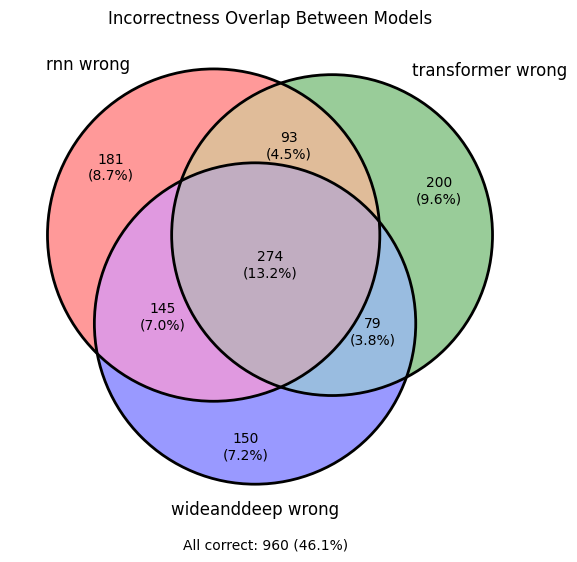

In [36]:
names = [k for k, _ in trained_models.items()]
# Define incorrectness sets: indices each model got incorrect
A = set(np.where(y_true != y_preds[0])[0])  # model 1 incorrect
B = set(np.where(y_true != y_preds[1])[0])  # model 2 incorrect
C = set(np.where(y_true != y_preds[2])[0])  # model 3 incorrect
total = len(y_true)

fig, ax = plt.subplots(figsize=(6, 6))
v = venn3([A, B, C], set_labels=[f"{names[0]} wrong", f"{names[1]} wrong", f"{names[2]} wrong"], ax=ax)
venn3_circles([A, B, C], ax=ax)

# Helper to set label counts + proportions
def set_label(region_key, count):
    lbl = v.get_label_by_id(region_key)
    if lbl:  # region might be empty
        lbl.set_text(f"{count}\n({count/total:.1%})")

# Compute region counts for incorrectness
only_A   = len(A - B - C)
only_B   = len(B - A - C)
only_C   = len(C - A - B)
A_B      = len((A & B) - C)
A_C      = len((A & C) - B)
B_C      = len((B & C) - A)
A_B_C    = len(A & B & C)
all_correct = total - (only_A + only_B + only_C + A_B + A_C + B_C + A_B_C)

# Apply to Venn regions
set_label('100', only_A)
set_label('010', only_B)
set_label('001', only_C)
set_label('110', A_B)
set_label('101', A_C)
set_label('011', B_C)
set_label('111', A_B_C)

# Annotate "all correct" outside the sets
ax.text(0.0, -0.75, f"All correct: {all_correct} ({all_correct/total:.1%})",
        ha="center", va="center", fontsize=10)

ax.set_title("Incorrectness Overlap Between Models")
plt.tight_layout()
plt.show()

In [37]:
# Plot the trainning loss vs the validation loss
def plot_training_histories(histories):
    if not histories:
        print("No histories to plot.")
        return

    for model_name, history in histories.items():
        plt.figure(figsize=(8, 5))
        plt.plot(history['train_loss'], label='Training Loss', color='blue', marker='o')
        plt.plot(history['val_loss'], label='Validation Loss', color='orange', marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training & Validation Loss for {model_name.upper()} Model')
        plt.legend()
        plt.grid(True)
        plt.show()

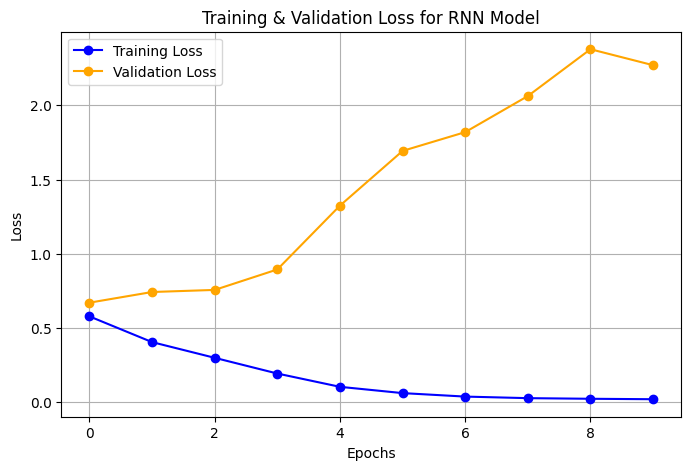

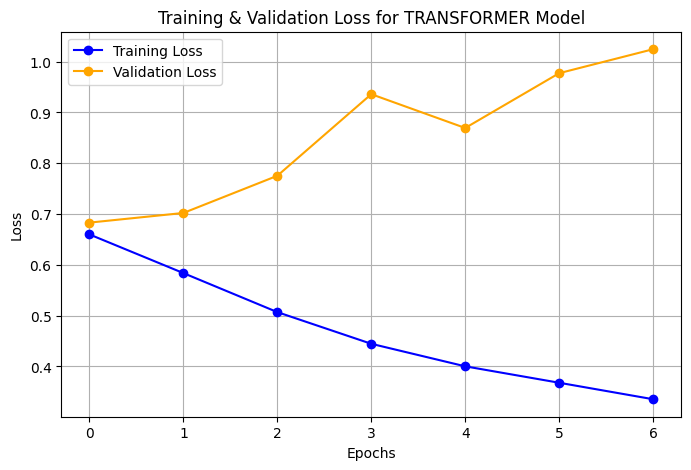

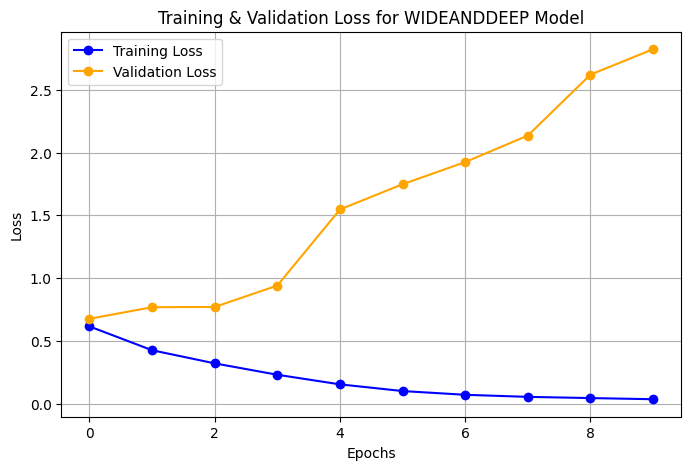

In [38]:
plot_training_histories(histories)

## Attention Ablation Study

In [39]:
# Define three classes of attention
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, sequence_output):
        scores = self.attention_net(sequence_output)
        weights = torch.softmax(scores, dim=1)
        context = torch.sum(weights * sequence_output, dim=1)
        return context, weights

def apply_cross_attention(source_seq, target_seq):
    scores = torch.bmm(source_seq, target_seq.transpose(1, 2))
    scores = scores / math.sqrt(source_seq.size(-1))
    weights = torch.softmax(scores, dim=-1)
    context = torch.bmm(weights, target_seq)
    return context, weights


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.mha = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=0.1,
            batch_first=True
        )
    
    def forward(self, sequence, padding_mask=None):
        output, weights = self.mha(
            sequence, sequence, sequence,
            key_padding_mask=padding_mask
        )
        return output, weights

In [40]:
class LSTMNNoAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.3, num_layers=2):
        super().__init__()
        # Use same structure as existing LSTMAttentionModel
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_ID)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, 
                           bidirectional=True, num_layers=num_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)
    
    def forward(self, x, mask=None, return_weights=False):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        # Mean-pool over sequence dimension
        pooled = lstm_out.mean(dim=1)
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        
        if return_weights:
            return logits, attn_weights
        return logits

class LSTMAdditiveAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.3, num_layers=2):
        super().__init__()
        # Use same structure as existing LSTMAttentionModel
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_ID)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, 
                           bidirectional=True, num_layers=num_layers, dropout=dropout)
        self.attention = AdditiveAttention(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)
    
    def forward(self, x, mask=None, return_weights=False):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        context, attn_weights = self.attention(lstm_out)
        context = self.dropout(context)
        logits = self.fc(context)
        
        if return_weights:
            return logits, attn_weights
        return logits

class LSTMCrossAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.3, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_ID)
        self.premise_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, 
                                   bidirectional=True, num_layers=num_layers, dropout=dropout)
        self.hypothesis_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, 
                                      bidirectional=True, num_layers=num_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 4, 2)  # hypo_pooled + cross_pooled
    
    def forward(self, x, mask=None, return_weights=False):
        # Split input using existing SEP_ID logic
        sep_positions = (x == SEP_ID).int().argmax(dim=1)
        batch_idx = torch.arange(x.size(0), device=x.device)
        token_range = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        premise_mask = token_range < sep_positions.unsqueeze(1)
        hypothesis_mask = token_range > sep_positions.unsqueeze(1)
        
        premise = torch.where(premise_mask, x, PAD_ID)
        hypothesis = torch.where(hypothesis_mask, x, PAD_ID)
        
        # Encode separately
        prem_emb = self.embedding(premise)
        hypo_emb = self.embedding(hypothesis)
        
        prem_encoded, _ = self.premise_lstm(prem_emb)
        hypo_encoded, _ = self.hypothesis_lstm(hypo_emb)
        
        # Cross attention (hypothesis attends to premise)
        cross_context, cross_weights = apply_cross_attention(hypo_encoded, prem_encoded)
        
        # Pool and combine
        hypo_pooled = hypo_encoded.mean(dim=1)
        cross_pooled = cross_context.mean(dim=1)
        combined = torch.cat([hypo_pooled, cross_pooled], dim=1)
        combined = self.dropout(combined)
        
        logits = self.fc(combined)
        
        if return_weights:
            return logits, cross_weights
        return logits

class LSTMMultiHeadAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.3, num_layers=2, num_heads=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_ID)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, 
                           bidirectional=True, num_layers=num_layers, dropout=dropout)
        self.multihead_attn = MultiHeadSelfAttention(hidden_dim * 2, num_heads)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)
    
    def forward(self, x, mask=None, return_weights=False):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        
        # Create padding mask from existing PAD_ID
        padding_mask = (x == PAD_ID)
        attn_out, attn_weights = self.multihead_attn(lstm_out, padding_mask=padding_mask)
        
        context = attn_out.mean(dim=1)
        context = self.dropout(context)
        logits = self.fc(context)
        
        if return_weights:
            return logits, attn_weights
        return logits

In [41]:
class TransformerAdditiveAttention(nn.Module):
    def __init__(self, embedding_matrix, n_heads, n_layers, dropout=0.3):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim
        
        # Use same embedding and transformer setup as existing TransformerClassifier
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), 
                                                     freeze=False, padding_idx=PAD_ID)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=max_combined_len, dropout=dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dropout=dropout,
            dim_feedforward=embed_dim*4, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Additive attention on transformer outputs
        self.additive_attention = AdditiveAttention(embed_dim)
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, 2)
        )

    def forward(self, src, src_mask):
        padding_mask = (src_mask == 0)
        embedded = self.embedding(src) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)
        encoded = self.transformer_encoder(pos_encoded, src_key_padding_mask=padding_mask)
        
        # Apply additive attention to all tokens (not just CLS)
        context, attn_weights = self.additive_attention(encoded)
        logits = self.classifier(context)
        return logits


class TransformerCrossAttention(nn.Module):
    def __init__(self, embedding_matrix, n_heads, n_layers, dropout=0.3):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim
        
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), 
                                                     freeze=False, padding_idx=PAD_ID)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=max_combined_len, dropout=dropout)
        
        # Separate encoders for premise and hypothesis
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dropout=dropout,
            dim_feedforward=embed_dim*4, batch_first=True
        )
        self.premise_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.hypothesis_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Cross-attention layer
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=embed_dim, num_heads=n_heads, dropout=dropout, batch_first=True
        )
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim * 2),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 2, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 2)
        )

    def forward(self, src, src_mask):
        # Split into premise and hypothesis using existing SEP_ID logic
        sep_positions = (src == SEP_ID).int().argmax(dim=1)
        batch_idx = torch.arange(src.size(0), device=src.device)
        token_range = torch.arange(src.size(1), device=src.device).unsqueeze(0)
        premise_mask = token_range < sep_positions.unsqueeze(1)
        hypothesis_mask = token_range > sep_positions.unsqueeze(1)
        
        premise = torch.where(premise_mask, src, PAD_ID)
        hypothesis = torch.where(hypothesis_mask, src, PAD_ID)
        
        # Create masks
        prem_padding_mask = (premise == PAD_ID)
        hypo_padding_mask = (hypothesis == PAD_ID)
        
        # Encode separately
        prem_emb = self.embedding(premise) * math.sqrt(self.d_model)
        hypo_emb = self.embedding(hypothesis) * math.sqrt(self.d_model)
        
        prem_encoded = self.pos_encoder(prem_emb)
        hypo_encoded = self.pos_encoder(hypo_emb)
        
        prem_output = self.premise_encoder(prem_encoded, src_key_padding_mask=prem_padding_mask)
        hypo_output = self.hypothesis_encoder(hypo_encoded, src_key_padding_mask=hypo_padding_mask)
        
        # Cross attention: hypothesis attends to premise
        cross_context, cross_weights = self.cross_attention(
            hypo_output, prem_output, prem_output,
            key_padding_mask=prem_padding_mask
        )
        
        # Use CLS token from hypothesis and cross-context
        hypo_cls = hypo_output[:, 0, :]
        cross_cls = cross_context[:, 0, :]
        
        combined = torch.cat([hypo_cls, cross_cls], dim=1)
        logits = self.classifier(combined)
        return logits

class TransformerMultiHead(nn.Module):
    def __init__(self, embedding_matrix, n_heads, n_layers, dropout=0.3):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim
        
        # Same base setup as existing TransformerClassifier
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), 
                                                     freeze=False, padding_idx=PAD_ID)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=max_combined_len, dropout=dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dropout=dropout,
            dim_feedforward=embed_dim*4, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Additional multi-head attention layer
        self.extra_multihead = MultiHeadSelfAttention(embed_dim, n_heads)
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, 2)
        )

    def forward(self, src, src_mask):
        padding_mask = (src_mask == 0)
        embedded = self.embedding(src) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)
        encoded = self.transformer_encoder(pos_encoded, src_key_padding_mask=padding_mask)
        
        # Apply additional multi-head attention
        enhanced_encoded, _ = self.extra_multihead(encoded, padding_mask=padding_mask)
        
        # Use CLS token for classification
        cls_output = enhanced_encoded[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

In [44]:
def instantiate_attention_models(rnn=False, transformer=False):
    models = {}
    # rnn Attention Variants
    if rnn:
        models.update({
            'LSTM_NoAttention': LSTMNNoAttention(
                vocab_size=vocab_size,
                embedding_dim=hyperparameters.embedding_dim['rnn'],
                hidden_dim=hyperparameters.hidden_dim['rnn'],
                dropout=hyperparameters.dropout,
                num_layers=hyperparameters.n_layers['rnn'],
            ).to(device),
            'LSTM_Additive': LSTMAdditiveAttention(
                vocab_size=vocab_size,
                embedding_dim=hyperparameters.embedding_dim['rnn'],
                hidden_dim=hyperparameters.hidden_dim['rnn'],
                dropout=hyperparameters.dropout,
                num_layers=hyperparameters.n_layers['rnn']
            ).to(device),
            'LSTM_Cross': LSTMCrossAttention(
                vocab_size=vocab_size,
                embedding_dim=hyperparameters.embedding_dim['rnn'],
                hidden_dim=hyperparameters.hidden_dim['rnn'],
                dropout=hyperparameters.dropout,
                num_layers=hyperparameters.n_layers['rnn']
            ).to(device),
            'LSTM_MultiHead': LSTMMultiHeadAttention(
                vocab_size=vocab_size,
                embedding_dim=hyperparameters.embedding_dim['rnn'],
                hidden_dim=hyperparameters.hidden_dim['rnn'],
                dropout=hyperparameters.dropout,
                num_layers=hyperparameters.n_layers['rnn'],
                num_heads=1
            ).to(device)
        })
    
    # Transformer Attention Variants
    if transformer:
        models.update({
            'Transformer_Additive': TransformerAdditiveAttention(
                embedding_matrix=embedding_matrix,
                n_heads=hyperparameters.n_heads['transformer'],
                n_layers=hyperparameters.n_layers['transformer'],
                dropout=hyperparameters.dropout
            ).to(device),
            'Transformer_Cross': TransformerCrossAttention(
                embedding_matrix=embedding_matrix,
                n_heads=hyperparameters.n_heads['transformer'],
                n_layers=hyperparameters.n_layers['transformer'],
                dropout=hyperparameters.dropout
            ).to(device),
            'Transformer_MultiHead': TransformerMultiHead(
                embedding_matrix=embedding_matrix,
                n_heads=hyperparameters.n_heads['transformer'],
                n_layers=hyperparameters.n_layers['transformer'],
                dropout=hyperparameters.dropout
            ).to(device)
        })
    
    return models

hyperparameters.lr =  {'rnn': 0.001, 'transformer': 0.0001, 'wideanddeep': 0.0005, 'LSTM_NoAttention': 0.001, 'LSTM_Additive': 0.001, 'LSTM_Cross': 0.001, 'LSTM_MultiHead': 0.001, 'Transformer_Additive': 0.0001, 'Transformer_Cross': 0.0001, 'Transformer_MultiHead': 0.0001}
hyperparameters.wd = {'rnn': 0.01, 'transformer': 0.0001, 'wideanddeep': 0.01, 'LSTM_NoAttention': 0.001, 'LSTM_Additive': 0.01, 'LSTM_Cross': 0.01, 'LSTM_MultiHead': 0.01, 'Transformer_Additive': 0.0001, 'Transformer_Cross': 0.0001, 'Transformer_MultiHead': 0.0001}

attention_models = instantiate_attention_models(rnn=True, transformer=True)


In [45]:
trained_attention_models, attention_histories = train_models(attention_models)

--- Training LSTM_NOATTENTION Model ---
Total trainable parameters: 4,273,578
Epoch 1/10 - Train loss: 0.5813, Train acc: 0.6869 - Val loss: 0.7324, Val acc: 0.6088
Epoch 2/10 - Train loss: 0.4325, Train acc: 0.8171 - Val loss: 0.7273, Val acc: 0.6065
Epoch 3/10 - Train loss: 0.3519, Train acc: 0.8606 - Val loss: 0.8066, Val acc: 0.5995
Epoch 4/10 - Train loss: 0.2765, Train acc: 0.8996 - Val loss: 0.8155, Val acc: 0.6211
Epoch 5/10 - Train loss: 0.2047, Train acc: 0.9319 - Val loss: 0.8596, Val acc: 0.6610
Epoch 6/10 - Train loss: 0.1493, Train acc: 0.9547 - Val loss: 1.0462, Val acc: 0.6710
Epoch 7/10 - Train loss: 0.1151, Train acc: 0.9684 - Val loss: 1.2414, Val acc: 0.6541
Epoch 8/10 - Train loss: 0.0916, Train acc: 0.9758 - Val loss: 1.2711, Val acc: 0.6679
Epoch 9/10 - Train loss: 0.0776, Train acc: 0.9803 - Val loss: 1.2881, Val acc: 0.6772
Epoch 10/10 - Train loss: 0.0640, Train acc: 0.9845 - Val loss: 1.6583, Val acc: 0.6641

Training completed in 23.31s (0.39 min)
Best valid

In [46]:
# Evaluate all attention models
evaluate_all_models(trained_attention_models)

--- Evaluating LSTM_NOATTENTION Model ---
Accuracy: 0.692
F1 Score: 0.571
Precision: 0.651
Recall: 0.508
----------------------------------------
              precision    recall  f1-score   support

     neutral       0.71      0.82      0.76      1243
     entails       0.65      0.51      0.57       839

    accuracy                           0.69      2082
   macro avg       0.68      0.66      0.67      2082
weighted avg       0.69      0.69      0.68      2082



Accuracy on samples WITH [UNK] tokens:   0.7207 (716 samples)
Accuracy on samples WITHOUT [UNK] tokens: 0.6772 (1366 samples)


--- Evaluating LSTM_ADDITIVE Model ---
Accuracy: 0.672
F1 Score: 0.602
Precision: 0.59
Recall: 0.614
----------------------------------------
              precision    recall  f1-score   support

     neutral       0.73      0.71      0.72      1243
     entails       0.59      0.61      0.60       839

    accuracy                           0.67      2082
   macro avg       0.66      0.66    

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 [array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
  array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
  array([0, 0, 0, ..., 1, 0, 0], dtype=int64),
  array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
  array([0, 0, 1, ..., 0, 0, 0], dtype=int64),
  array([1, 0, 1, ..., 0, 0, 0], dtype=int64),
  array([1, 0, 0, ..., 0, 0, 0], dtype=int64)])

## Qualitative Analysis

In [47]:
def plot_rnn_attention(tokens, attention_weights):
    # 1. Remove padding from tokens for a cleaner plot
    try:
        real_len = tokens.index('[PAD]')
        tokens_no_padding = tokens[:real_len]
        weights_no_padding = attention_weights.squeeze().cpu().numpy()[:real_len]
    except ValueError:
        tokens_no_padding = tokens
        weights_no_padding = attention_weights.squeeze().cpu().numpy()

    # 2. Create the bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=tokens_no_padding, y=weights_no_padding, palette='viridis')
    plt.title('RNN Attention Weights')
    plt.xlabel('Tokens')
    plt.ylabel('Attention Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [48]:
#Specific Plot for transformer
def plot_attention_head(attention_weights, tokens, head_index):
    """Plots a readable heatmap for a single attention head, ignoring padding."""
    
    # 1. Find the actual length of the sentence by finding the first [PAD] token
    try:
        real_len = tokens.index('[PAD]')
    except ValueError:
        real_len = len(tokens)

    # 2. Slice the tokens and weights to remove padding
    tokens_no_padding = tokens[:real_len]
    head_weights = attention_weights[0, head_index][:real_len, :real_len]
    
    # 3. Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        head_weights, 
        xticklabels=tokens_no_padding, 
        yticklabels=tokens_no_padding, 
        cmap='viridis', 
        ax=ax
    )
    
    ax.set_title(f'Attention Head #{head_index}')
    plt.show()


In [49]:
# Master function to visualize attention
def visualize_attention(model_name, model, sample_token_ids, sample_mask):

    print(f"--- Visualizing Attention for {model_name.upper()} Model ---")
    
    # Convert token IDs back to words for plotting
    plot_tokens = [id2word[int(token_id)] for token_id in sample_token_ids]
    
    model.eval() # Set model to evaluation mode
    
    # Add a batch dimension for model input
    sample_token_ids = sample_token_ids.unsqueeze(0).to(device)
    sample_mask = sample_mask.unsqueeze(0).to(device)

    if model_name in ['gru', 'lstm']:
        # For RNNs, call forward with return_weights=True
        _, attention_weights = model(sample_token_ids, sample_mask, return_weights=True)
        plot_rnn_attention(plot_tokens, attention_weights.detach())
        
    elif model_name == 'transformer':
        # For Transformer, call the special get_attention_weights method
        attention_weights = model.get_attention_weights(sample_token_ids, sample_mask)
        
        # Plot the attention for each head
        num_heads = attention_weights.shape[1]
        for i in range(num_heads):
            plot_attention_head(attention_weights.detach().cpu().numpy(), plot_tokens, head_index=i)
    else:
        print(f"Attention visualization for model type '{model_name}' is not supported yet.")

--- Visualizing Attention for TRANSFORMER Model ---


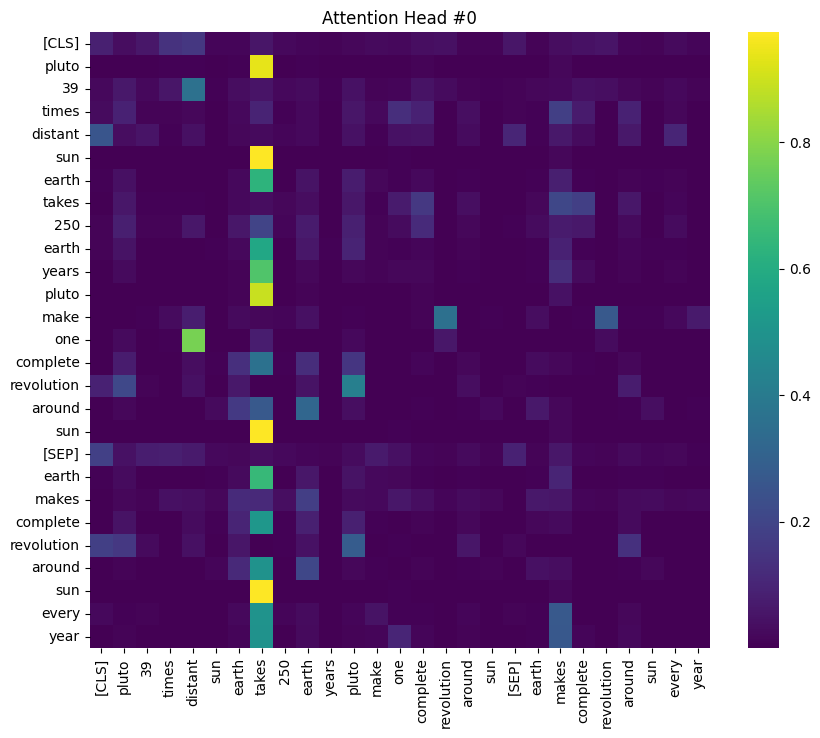

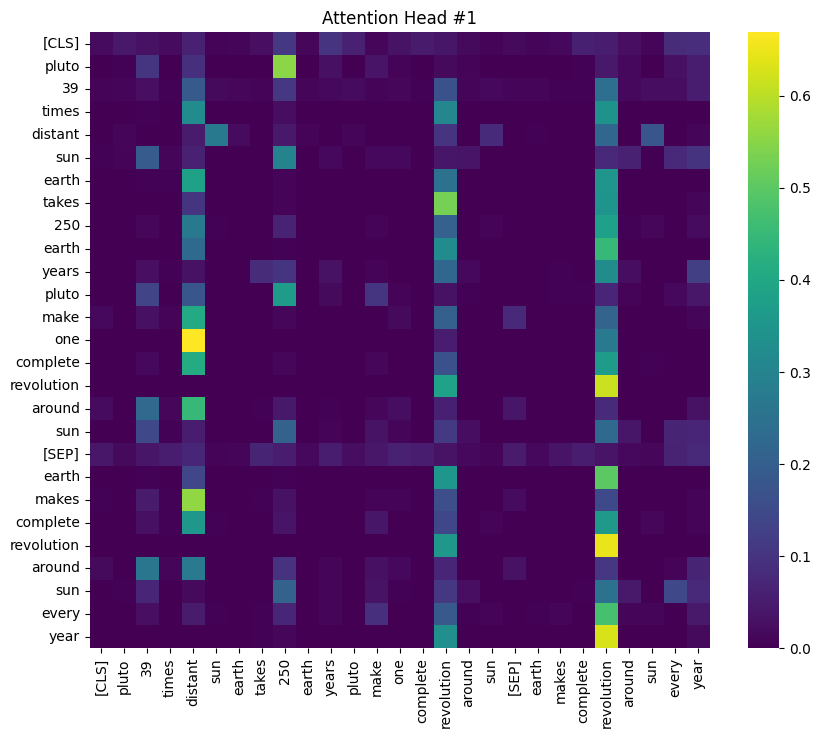

In [50]:
# Select a sample to visualize (e.g., the 5th sentence in the training set)
sample_idx = 5
sample_tokens = x_train[sample_idx]
sample_mask = train_masks[sample_idx]

# Visualize attention for the trained GRU model
if 'gru' in trained_models:
    visualize_attention('gru', trained_models['gru'], sample_tokens, sample_mask)

if 'lstm' in trained_models:
    visualize_attention('lstm', trained_models['lstm'], sample_tokens, sample_mask)

# Visualize attention for the trained Transformer model
if 'transformer' in trained_models:
    visualize_attention('transformer', trained_models['transformer'], sample_tokens, sample_mask)